In [ ]:
!pip install ortools

In [ ]:
import random
import time
import statistics
import sys
import math
import itertools
from ortools.linear_solver import pywraplp
import numpy as np

In [ ]:

np.random.seed(42)

N = 25       # número total de jogadores
K = 4       # número de atributos (ex: habilidade, velocidade, físico, goleiro)
TEAM_SIZE = 5 # tamanho do time
alpha = 1
# Matriz de atributos: N x K
# Jogador i está na linha i
players = np.random.randint(1, 4, size=(N, K))

players


array([[3, 1, 3, 3],
       [1, 1, 3, 2],
       [3, 3, 3, 3],
       [1, 3, 2, 1],
       [2, 2, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 1, 3],
       [3, 3, 2, 3],
       [2, 2, 3, 2],
       [3, 3, 1, 3],
       [1, 3, 3, 1],
       [1, 3, 2, 1],
       [2, 2, 2, 1],
       [2, 1, 2, 3],
       [3, 1, 3, 3],
       [2, 1, 2, 2],
       [2, 2, 2, 2],
       [2, 1, 3, 2],
       [2, 2, 2, 2],
       [2, 3, 3, 2],
       [3, 1, 2, 1],
       [1, 2, 3, 1],
       [2, 1, 1, 1],
       [1, 3, 1, 1],
       [1, 3, 1, 1]])

In [ ]:
solution = greedy_randomized_construction(players, TEAM_SIZE, alpha)
print("=== SOLUÇÃO INICIAL (GREEDY RANDOMIZED) ===")
print("Solução inicial:", solution)
print("Score dos times:", team_scores_from_solution(solution, players, TEAM_SIZE))
print("Função objetivo:", objective_quadratic(solution, players, TEAM_SIZE))

=== SOLUÇÃO INICIAL (GREEDY RANDOMIZED) ===
Solução inicial: [14  6 24 16  1 17 12  3 23 10 13 20 11 18 22  7  2  9 21 15  4  8 19  0
  5]
Score dos times: [37. 36. 35. 47. 43.]
Função objetivo: 107.2


In [ ]:
best_solution, best_value, elapsed_time = tabu_search(
    initial_solution=solution,
    players=players,
    team_size=TEAM_SIZE,
    num_teams=N//TEAM_SIZE,
    tabu_tenure=3,
    BTmax=10
)

print("\nResultado Tabu Search")
print("Melhor solução:", best_solution)
print("Score dos times:", team_scores_from_solution(best_solution, players, TEAM_SIZE))
print("Função objetivo:", best_value)
print("Tempo (s):", elapsed_time)



Resultado Tabu Search
Melhor solução: [ 7  6 24  9  1 14 16  3 23 10 19 12 11 18 17 13  2 22 20 15  4  8 21  0
  5]
Score dos times: [40. 39. 40. 39. 40.]
Função objetivo: 1.2
Tempo (s): 7.883191108703613


In [ ]:

# Solução via Simulated Annealing
sa_solution, sa_time = simulated_annealing(
    initial_solution=solution,
    players=players,
    team_size=TEAM_SIZE,
    T0=1.78,
    alpha=0.95,
    SAmax=N,
    Tmin=1e-3
)

print("=== SOLUÇÃO FINAL (SIMULATED ANNEALING) ===")
print("Solução:", sa_solution)
print("Score dos times:", team_scores_from_solution(sa_solution, players, TEAM_SIZE))
print("Função objetivo:", objective_quadratic(sa_solution, players, TEAM_SIZE))
print(f"Tempo de execução: {sa_time:.4f} segundos")

=== SOLUÇÃO INICIAL (GREEDY RANDOMIZED) ===
Solução inicial: [12 10  7 13 18  4  8  2 23 11 20  1 22 21  0 14 24  3  9 17  5  6 19 16
 15]
Score dos times: [42. 42. 36. 41. 37.]
Função objetivo: 33.2
T0: 50.5
=== SOLUÇÃO FINAL (SIMULATED ANNEALING) ===
Solução: [22 10  7 13 18  6  8  2 23 11  4  1 12 21  0 14 24  3  9 15 20 17 19 16
  5]
Score dos times: [40. 40. 39. 40. 39.]
Função objetivo: 1.2
Tempo de execução: 1.8968 segundos


In [ ]:
result = solve_balanced_teams(players, T=N//TEAM_SIZE, team_size=TEAM_SIZE, time_limit= 3)

print("Status:", result['status'])
print("Tempo:", result['time'])
print("Diferença máxima:", result['range'])
print("Times:", team_assignment_to_permutation(result['solution'],TEAM_SIZE))
# print("Score dos times:", result['team_scores'])
print("Score dos times :", team_scores_from_solution(result['solution'], players, TEAM_SIZE))
print("Score quadrático total da solução:", objective_quadratic(team_assignment_to_permutation(result['solution'],TEAM_SIZE),players))

Status: FEASIBLE
Tempo: 3.008765459060669
Diferença máxima: 0.1999999999999904
Times: [0, 5, 8, 17, 20, 1, 2, 10, 16, 22, 11, 14, 15, 18, 21, 6, 9, 13, 19, 23, 3, 4, 7, 12, 24]
Score dos times : [40. 42. 46. 48. 44.]
Score quadrático total da solução: 1.2


Método exato

In [ ]:
from ortools.sat.python import cp_model

In [ ]:

def solve_balanced_teams(players, T, team_size, weights=None, time_limit=10):
    start = time.time()

    N, K = players.shape  # N jogadores, K atributos

    if weights is None:
        weights = np.ones(K)

    solver = pywraplp.Solver.CreateSolver('SCIP')

    if not solver:
        raise Exception("Solver não disponível")

    # Variáveis: x[i][t] = 1 se jogador i está no time t
    x = {}
    for i in range(N):
        for t in range(T):
            x[i, t] = solver.BoolVar(f'x_{i}_{t}')


    #Fixar um jogador em um time, para reduzir combinaçoes possiveis
    solver.Add(x[0,0] == 1)

    # Cada jogador só pode estar em um time
    for i in range(N):
        solver.Add(sum(x[i, t] for t in range(T)) == 1)

    # Cada time deve ter exatamente team_size jogadores
    for t in range(T):
        solver.Add(sum(x[i, t] for i in range(N)) == team_size)

    # Score de cada jogador (média ponderada dos atributos)
    player_score = np.dot(players, weights)

    # Variáveis: score do time t
    S = {}
    for t in range(T):
        S[t] = solver.NumVar(0, solver.infinity(), f'S_{t}')

    # Definição do score de cada time
    for t in range(T):
        solver.Add(
            S[t] == sum(player_score[i] * x[i, t] for i in range(N)) / team_size
        )

    # Best e worst team
    Smax = solver.NumVar(0, solver.infinity(), 'Smax')
    Smin = solver.NumVar(0, solver.infinity(), 'Smin')

    for t in range(T):
        solver.Add(S[t] <= Smax)
        solver.Add(S[t] >= Smin)

    # Objetivo: minimizar diferença
    solver.Minimize(Smax - Smin)

    solver.SetTimeLimit(time_limit * 1000)



    status = solver.Solve()
    end = time.time()


    status_map = {
        pywraplp.Solver.OPTIMAL: "OPTIMAL",
        pywraplp.Solver.FEASIBLE: "FEASIBLE",
        pywraplp.Solver.INFEASIBLE: "INFEASIBLE",
        pywraplp.Solver.UNBOUNDED: "UNBOUNDED",
        pywraplp.Solver.ABNORMAL: "ABNORMAL",
        pywraplp.Solver.NOT_SOLVED: "NOT_SOLVED"
    }


    if status in [pywraplp.Solver.OPTIMAL, pywraplp.Solver.FEASIBLE]:
        solution = [-1]*N

        for i in range(N):
            for t in range(T):
                if x[i, t].solution_value() > 0.5:
                    solution[i] = t

        team_scores = [S[t].solution_value() for t in range(T)]

        return {
            "solution": solution,
            "team_scores": team_scores,
            "range": Smax.solution_value() - Smin.solution_value(),
            "time": end - start,
            "status": status_map.get(status, "UNKNOWN")
        }

    else:
        return {
            "solution": None,
            "team_scores": None,
            "range": None,
            "time": end - start,
            "status": status_map.get(status, "UNKNOWN")
        }


In [ ]:
def team_assignment_to_permutation(assignments, team_size):
    """
    assignments: vector where index = player, value = team_id
    returns: permutation solution for your metaheuristic
    """
    N = len(assignments)
    T = max(assignments) + 1

    solution = [None] * N

    # group players by team
    team_buckets = {t: [] for t in range(T)}

    for player, team in enumerate(assignments):
        team_buckets[team].append(player)

    # fill solution respecting team index blocks
    idx = 0
    for t in range(T):
        if len(team_buckets[t]) != team_size:
            raise ValueError(f"Team {t} has {len(team_buckets[t])} players (expected {team_size})")

        for player in team_buckets[t]:
            solution[idx] = player
            idx += 1

    return solution


Funcao objetivo

In [ ]:
def team_scores_from_solution(solution, players, team_size=5, weights=None):
    """
    Calcula os scores de cada time diretamente a partir da solução.

    • solution: array do tipo [0..N-1] em alguma permutação
    • players: matriz N x K com atributos dos jogadores
    • team_size: tamanho do time (default = 5)
    • weights: pesos opcionais por atributo

    Usa a regra:
        time = índice // team_size
    """
    solution = np.asarray(solution, dtype=int)
    players = np.asarray(players)

    N = players.shape[0]

    assert solution.size == N, "solution deve ter tamanho N (número de jogadores)"
    assert N % team_size == 0, "N deve ser múltiplo do tamanho do time"

    T = N // team_size
    scores = np.zeros(T)

    if weights is None:
        # Versão sem pesos
        for idx, player_id in enumerate(solution):
            team = idx // team_size
            scores[team] += np.sum(players[player_id])
    else:
        weights = np.asarray(weights)
        assert weights.shape[0] == players.shape[1], "Weights deve ter tamanho K"

        for idx, player_id in enumerate(solution):
            team = idx // team_size
            scores[team] += np.sum(players[player_id] * weights)

    return scores

In [ ]:
def objective_quadratic(solution, players, team_size=5, weights=None):
    """
    Função objetivo quadrática:

        f(S) = Σ (Score_t - μ)²

    onde μ é a média dos scores dos times.
    """
    scores = team_scores_from_solution(solution, players, team_size, weights)
    mu = np.mean(scores)

    return np.sum((scores - mu)**2)

Método Construtivo Guloso Randomizado

In [ ]:
def greedy_randomized_construction(players, team_size=5, alpha=0.3, weights=None):
    """
    Constrói uma solução inicial usando um algoritmo guloso randomizado (estilo GRASP)
    compatível com representação: índice -> time = idx // team_size
    """

    players = np.asarray(players)
    N, K = players.shape
    T = N // team_size

    # Score individual de cada jogador
    if weights is None:
        player_scores = players.sum(axis=1)
    else:
        weights = np.asarray(weights)
        player_scores = np.sum(players * weights, axis=1)

    # Score médio ideal de um time
    target = np.sum(player_scores) / T

    # Lista de jogadores disponíveis
    available = list(range(N))

    # Solução a ser construída
    solution = np.empty(N, dtype=int)

    # Score parcial dos times
    team_scores = np.zeros(T)

    for pos in range(N):
        team = pos // team_size

        # Calcula custo de inserir cada jogador disponível
        costs = []

        for player in available:
            cost = abs((team_scores[team] + player_scores[player]) - target)
            costs.append((player, cost))

        # Ordena pelo custo
        costs.sort(key=lambda x: x[1])

        min_cost = costs[0][1]
        max_cost = costs[-1][1]

        # Monta RCL
        threshold = min_cost + alpha * (max_cost - min_cost)
        RCL = [player for player, cost in costs if cost <= threshold]

        # Escolhe aleatoriamente da RCL
        chosen = np.random.choice(RCL)

        # Atualiza solução
        solution[pos] = chosen
        team_scores[team] += player_scores[chosen]
        available.remove(chosen)

    return solution


Vizinhancas

In [ ]:
def neighborhood_inter_team_swap_gen(solution, team_size=5):
    N = len(solution)

    for i in range(N):
        for j in range(i+1, N):

            if (i // team_size) != (j // team_size):
                s = solution.copy()
                s[i], s[j] = s[j], s[i]
                yield s

In [ ]:

def neighborhood_inter_team_full_cycle_gen(solution, team_size=5):
    """
    Generates (with yield) ALL possible cyclic inter-team shifts.
    One player from each team is chosen and cyclically shifted.

    WARNING:
    Number of neighbors grows as (team_size ^ number_of_teams)
    """

    N = len(solution)
    num_teams = N // team_size

    # Indices belonging to each team
    team_indices = [
        list(range(t * team_size, (t + 1) * team_size))
        for t in range(num_teams)
    ]

    # One index choice per team (cartesian product)
    for combo in itertools.product(*team_indices):

        new_solution = solution.copy()
        chosen_players = [new_solution[idx] for idx in combo]

        # cyclic shift across ALL teams
        for i in range(num_teams):
            new_solution[combo[(i + 1) % num_teams]] = chosen_players[i]

        yield new_solution


SA

In [ ]:
def simulated_annealing(
    initial_solution,
    players,
    team_size,
    T0=1.78,
    alpha=0.95,
    SAmax=100,
    Tmin=1e-3
):

    # Função objetivo
    def f(sol):
        return objective_quadratic(sol, players, team_size=team_size)
    start = time.time()
    s = initial_solution
    s_best = s
    T0, _ = estimate_T0_from_greedy(
          players=players,
          team_size=team_size,
          n_solutions=30
      )
    T = T0
    # print("T0:", T0)

    while T > Tmin:
        IterT = 0

        # Escolhe aleatoriamente qual vizinhança usar nessa temperatura
        if random.random() < 0.5:
            neighbors = neighborhood_inter_team_swap_gen(s,team_size)
        else:
            neighbors = neighborhood_inter_team_full_cycle_gen(s,team_size)

        while IterT < SAmax:
            IterT += 1

            try:
                s_candidate = next(neighbors)
            except StopIteration:
                break

            delta = f(s_candidate) - f(s)

            if delta < 0:
                s = s_candidate

                if f(s) < f(s_best):
                    s_best = s

            else:
                if random.random() < math.exp(-delta / T):
                    s = s_candidate

        # Atualiza temperatura
        T *= alpha

    return s_best,objective_quadratic(s_best,players,team_size), time.time() - start


In [ ]:
def estimate_initial_temperature(
    s0,
    players,
    team_size,
    beta=1.3,
    gamma=0.8,
    SAmax=40,
    T0=50
):
    """
    Baseado integralmente no seu pseudocódigo de TemperaturaInicial
    """

    T = T0
    continue_loop = True

    f_s = objective_quadratic(s0, players, team_size)

    while continue_loop:
        accepted = 0

        for _ in range(SAmax):

            if random.random() < 0.5:
              neighbors = neighborhood_inter_team_swap_gen(s0)
            else:
              neighbors = neighborhood_inter_team_full_cycle_gen(s0)

            s_prime = next(neighbors)
            f_s_prime = objective_quadratic(s_prime, players, team_size)

            delta = f_s_prime - f_s

            if delta < 0:
                accepted += 1
            else:
                x = random.random()
                if x < np.exp(-delta / T):
                    accepted += 1

        # Critério de parada: taxa de aceitação atingida
        if accepted >= gamma * SAmax:
            continue_loop = False
        else:
            T = beta * T

    return T

In [ ]:
def estimate_T0_from_greedy(players, team_size=5, alpha=0.3, n_solutions=10):

    temperatures = []
    N = len(players)
    for _ in range(n_solutions):
        solution = greedy_randomized_construction(players, team_size, alpha)

        T = estimate_initial_temperature(
            solution,
            players,
            team_size,
            SAmax= N
        )

        temperatures.append(T)

    return float(np.mean(temperatures)), temperatures


In [ ]:
T0, all_Ts = estimate_T0_from_greedy(
    players,
    team_size=5,
    alpha=0.4,
    n_solutions=30
)

print("T0 estimado:", T0)
print("Temperaturas individuais:", all_Ts)


NameError: name 'players' is not defined

Tabu Search


In [ ]:
def generate_neighbors(solution, team_size, max_neighbors=500):
    """
    Gera vizinhos usando:
    1) inter_team_swap (nível 1)
    2) inter_team_full_cycle (shift circular)
    Seleciona a vizinhança de forma aleatória
    """

    gens = [
        lambda: neighborhood_inter_team_swap_gen(solution, team_size),
        lambda: neighborhood_inter_team_full_cycle_gen(solution, team_size)
    ]

    i = 0

    while i < max_neighbors:
        gen = np.random.choice(gens)

        neighbor_gen = gen()

        try:
            neighbor = next(neighbor_gen)
            yield neighbor
            i += 1
        except StopIteration:
            # Caso esse gerador não tenha mais vizinhos, sorteia outro
            continue


In [ ]:
def best_improvement_neighbor(
    solution,
    players,
    team_size,
    num_teams,
    tabu_list,
    aspiration_value
):
    """
    Retorna o melhor vizinho admissível (Best Improvement):
    - não tabu, ou
    - atende a condição de aspiração
    """

    best_neighbor = None
    best_value = float('-inf')
    best_move = None

    current_value = objective_quadratic(solution, players, team_size)

    for neighbor in generate_neighbors(solution, team_size):

        move = tuple(neighbor)  # Representação do movimento (simplificada)

        value = objective_quadratic(neighbor, players, team_size)

        # -------- Condição tabu + aspiração -------- #
        is_tabu = move in tabu_list
        aspiration = value > aspiration_value

        if not is_tabu or aspiration:

            if value > best_value:
                best_value = value
                best_neighbor = neighbor
                best_move = move

    return best_neighbor, best_value, best_move


In [ ]:
from collections import deque

def tabu_search(
    initial_solution,
    players,
    team_size,
    num_teams,
    tabu_tenure=6,
    BTmax=10
):
    start = time.time()

    s = initial_solution.copy()
    s_best = s.copy()

    best_value = objective_quadratic(s_best, players, team_size)
    current_value = best_value

    Iter = 0
    MelhorIter = 0

    # Lista Tabu (deque para controlar tamanho)
    tabu_list = deque(maxlen=tabu_tenure)

    while (Iter - MelhorIter) <= BTmax:

        Iter += 1

        best_candidate = None
        best_candidate_value = float('inf')
        best_candidate_move = None

        # Geração dos vizinhos
        for neighbor in generate_neighbors(s, team_size=team_size,max_neighbors=1000):

            move = tuple(neighbor)
            value = objective_quadratic(neighbor, players, team_size)

            is_tabu = move in tabu_list
            aspiration = value < best_value

            if (not is_tabu) or aspiration:
                if value < best_candidate_value:
                    best_candidate = neighbor
                    best_candidate_value = value
                    best_candidate_move = move

        # Se não achou nada admissível, para
        if best_candidate is None:
            break

        # Atualiza solução corrente
        s = best_candidate
        current_value = best_candidate_value

        # Atualiza lista tabu
        tabu_list.append(best_candidate_move)

        # Atualiza melhor solução global
        if current_value < best_value:
            s_best = s.copy()
            best_value = current_value
            MelhorIter = Iter


    return s_best, best_value, time.time() - start


Experimento


In [ ]:

def generate_players(N, K, seed=None):
    if seed is not None:
        np.random.seed(seed)
    players = np.random.randint(1, 4, size=(N, K))
    return players, seed


In [ ]:
import time
import pandas as pd
import numpy as np

def run_experiments(
    team_size=5,
    alpha=0.3,
    N_values=[20, 40, 60],
    K_values=[4, 10, 20],
    n_runs=30
):

    results = []
    global_start = time.time()

    # Guardar as matrizes base fixas para cada cenário
    players_base = {}

    # Criar jogadores fixos por (N,K)
    for N in N_values:
        for K in K_values:

            base_seed = 1000 + 10*N + K
            players, seed_players = generate_players(N, K, seed=base_seed)

            players_base[(N, K)] = {
                "players": players,
                "seed_players": seed_players
            }

    # Rodar os experimentos
    for N in N_values:
        for K in K_values:

            print(f"\n{'='*50}")
            print(f"Iniciando cenário N={N}, K={K}")
            print(f"{'='*50}")

            scenario_start = time.time()

            players = players_base[(N, K)]["players"]
            seed_players = players_base[(N, K)]["seed_players"]

            num_teams = N // team_size

            for run in range(n_runs):

                run_start = time.time()

                seed_solution = 10000 + run
                np.random.seed(seed_solution)

                # Solução inicial
                solution = greedy_randomized_construction(
                    players,
                    team_size=team_size,
                    alpha=alpha
                )

                # =====================
                # TABU SEARCH
                # =====================
                tabu_start = time.time()

                best_sol, best_cost, tabu_time = tabu_search(
                    initial_solution=solution,
                    players=players,
                    team_size=team_size,
                    num_teams=num_teams,
                    tabu_tenure=3,
                    BTmax=10
                )

                tabu_end = time.time()

                results.append({
                    "N": N,
                    "K": K,
                    "TEAM_SIZE": team_size,
                    "num_teams": num_teams,
                    "algorithm": "Tabu Search",
                    "run": run,
                    "seed_players": seed_players,
                    "seed_solution": seed_solution,
                    "cost": best_cost,
                    "time": tabu_time
                })

                # =====================
                # SIMULATED ANNEALING
                # =====================

                sa_start = time.time()

                sa_solution, sa_cost, sa_time = simulated_annealing(
                    initial_solution=solution,
                    players=players,
                    team_size=team_size,
                    T0=1.78,
                    alpha=0.95,
                    SAmax=N,
                    Tmin=1e-3
                )

                sa_end = time.time()

                results.append({
                    "N": N,
                    "K": K,
                    "TEAM_SIZE": team_size,
                    "num_teams": num_teams,
                    "algorithm": "Simulated Annealing",
                    "run": run,
                    "seed_players": seed_players,
                    "seed_solution": seed_solution,
                    "cost": sa_cost,
                    "time": sa_time
                })

                # =====================
                # SCIP (solve_balanced_teams)
                # =====================

                scip_start = time.time()

                result = solve_balanced_teams(
                    players,
                    T=num_teams,
                    team_size=team_size,
                    time_limit=3
                )

                scip_end = time.time()

                perm = team_assignment_to_permutation(
                    result["solution"],
                    team_size
                )

                scip_cost = objective_quadratic(perm, players)
                scip_time = result["time"]

                results.append({
                    "N": N,
                    "K": K,
                    "TEAM_SIZE": team_size,
                    "num_teams": num_teams,
                    "algorithm": "SCIP",
                    "run": run,
                    "seed_players": seed_players,
                    "seed_solution": seed_solution,
                    "cost": scip_cost,
                    "time": scip_time
                })

                run_end = time.time()

                # =====================
                # PRINTS
                # =====================

                print(f"\nRun {run+1}/{n_runs} — N={N}, K={K}")
                print(f"   Tabu Search:        {tabu_end - tabu_start:.4f}s")
                print(f"   Simulated Annealing:{sa_end - sa_start:.4f}s")
                print(f"   SCIP:               {scip_end - scip_start:.4f}s")
                print(f"   Total run time:     {run_end - run_start:.4f}s")

            scenario_end = time.time()

            print(f"\n>>> Tempo total do cenário N={N}, K={K}: {scenario_end - scenario_start:.2f} segundos")

    global_end = time.time()
    print(f"\n{'='*50}")
    print(f"TEMPO TOTAL DO EXPERIMENTO: {global_end - global_start:.2f} segundos")
    print(f"{'='*50}")

    # Criar DataFrame final
    df = pd.DataFrame(results)

    return df


In [ ]:
df_results = run_experiments(team_size=5)

df_results.to_csv("results_experiments.csv", index=False)



Iniciando cenário N=20, K=4

Run 1/30 — N=20, K=4
   Tabu Search:        4.1775s
   Simulated Annealing:1.0759s
   SCIP:               3.0157s
   Total run time:     8.2707s

Run 2/30 — N=20, K=4
   Tabu Search:        2.7781s
   Simulated Annealing:0.9679s
   SCIP:               3.0116s
   Total run time:     6.7590s

Run 3/30 — N=20, K=4
   Tabu Search:        2.6509s
   Simulated Annealing:1.7111s
   SCIP:               3.0145s
   Total run time:     7.3777s

Run 4/30 — N=20, K=4
   Tabu Search:        2.6125s
   Simulated Annealing:0.9559s
   SCIP:               3.0124s
   Total run time:     6.5821s

Run 5/30 — N=20, K=4
   Tabu Search:        2.8748s
   Simulated Annealing:1.2919s
   SCIP:               3.0124s
   Total run time:     7.1802s

Run 6/30 — N=20, K=4
   Tabu Search:        3.4909s
   Simulated Annealing:1.1046s
   SCIP:               3.0137s
   Total run time:     7.6107s

Run 7/30 — N=20, K=4
   Tabu Search:        2.9601s
   Simulated Annealing:1.0543s
   SCIP:   

Análise de resultados

In [1]:
!pip install matplotlib seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
CSV_PATH = "results_experiments_1.csv"
OUTPUT_DIR = "plots"

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

sns.set(style="whitegrid", font_scale=1.1)

In [5]:
df = pd.read_csv(CSV_PATH)

print("\nLinhas:", len(df))
print("\nColunas:", df.columns)


Linhas: 810

Colunas: Index(['N', 'K', 'TEAM_SIZE', 'num_teams', 'algorithm', 'run', 'seed_players',
       'seed_solution', 'cost', 'time'],
      dtype='object')


In [6]:
summary = df.groupby(["N", "K", "algorithm"]).agg(
    mean_cost=("cost", "mean"),
    std_cost=("cost", "std"),
    min_cost=("cost", "min"),
    mean_time=("time", "mean"),
    std_time=("time", "std")
).reset_index()

summary.to_csv(f"{OUTPUT_DIR}/summary.csv", index=False)
print("\nSummary saved: summary.csv")


Summary saved: summary.csv


In [8]:
summary

,N,K,algorithm,mean_cost,std_cost,min_cost,mean_time,std_time
0,20,4,SCIP,1.000000,0.000000,1.000000,3.005482,0.001399
1,20,4,Simulated Annealing,1.000000,0.000000,1.000000,1.085827,0.217893
2,20,4,Tabu Search,28.600000,12.997613,11.000000,3.144584,0.942456
3,20,10,SCIP,0.750000,0.000000,0.750000,3.005468,0.001097
4,20,10,Simulated Annealing,0.750000,0.000000,0.750000,1.096976,0.178577
5,20,10,Tabu Search,15.550000,12.098447,2.750000,3.034296,0.874209
6,20,20,SCIP,1.000000,0.000000,1.000000,3.005810,0.001625
7,20,20,Simulated Annealing,10.733333,9.892294,1.000000,1.097015,0.258459
8,20,20,Tabu Search,174.133333,61.652381,49.000000,3.356730,0.749537
9,40,4,SCIP,1.875000,0.000000,1.875000,3.012109,0.002769


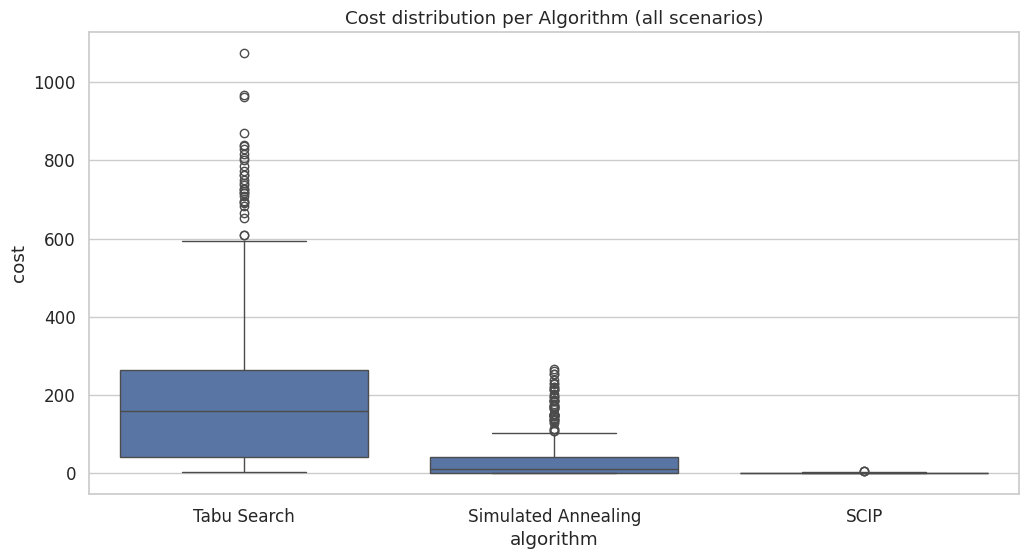

In [10]:
# ============================================
# 3. Cost vs Algorithm (per N,K)
# ============================================

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="algorithm", y="cost")
plt.title("Cost distribution per Algorithm (all scenarios)")
plt.savefig(f"{OUTPUT_DIR}/boxplot_cost_all.png", dpi=300)
plt.show()
plt.close()


In [11]:
# Per (N, K)
for (N, K), sub in df.groupby(["N", "K"]):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=sub, x="algorithm", y="cost")
    plt.title(f"Cost Distribution - N={N}, K={K}")
    plt.savefig(f"{OUTPUT_DIR}/boxplot_cost_N{N}_K{K}.png", dpi=300)
    plt.close()

print("✅ Boxplots gerados")

✅ Boxplots gerados


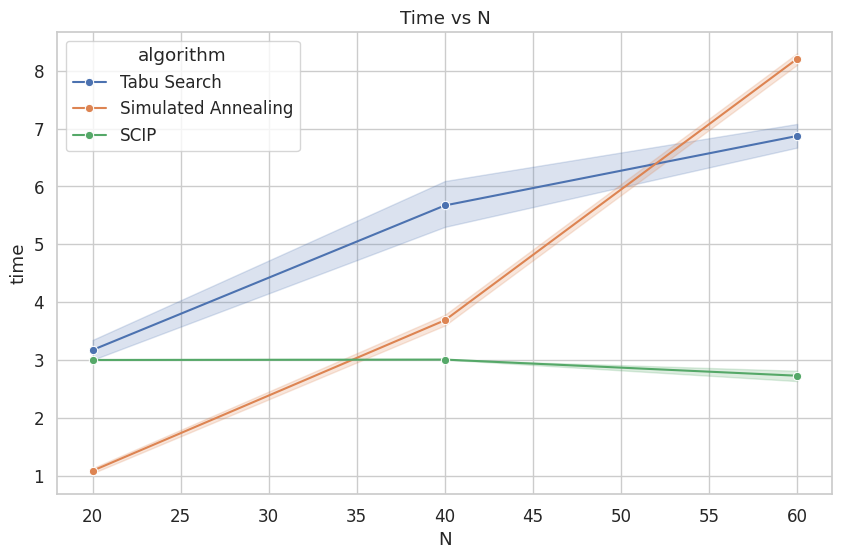

In [13]:
# ============================================
# 4. Time vs N (scalability)
# ============================================

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="N", y="time", hue="algorithm", marker="o")
plt.title("Time vs N")
plt.savefig(f"{OUTPUT_DIR}/time_vs_N.png", dpi=300)
plt.show()
plt.close()


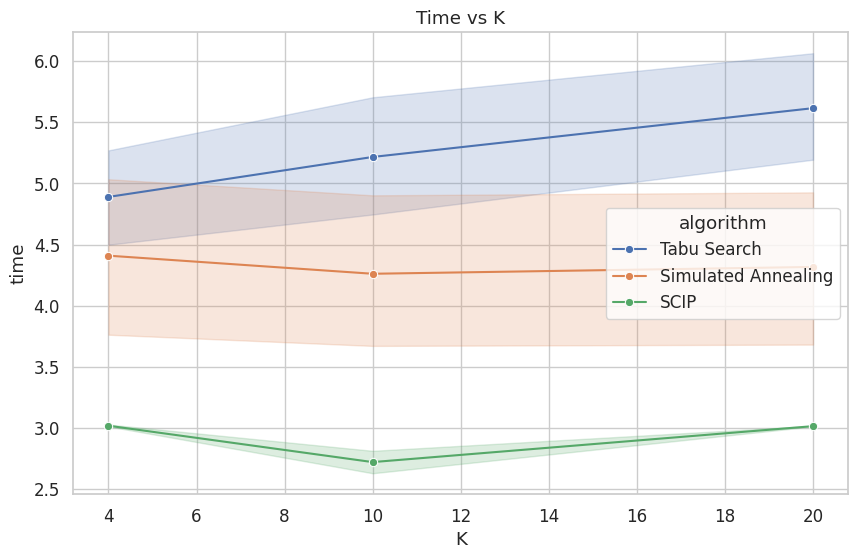

✅ Scalability plots gerados


In [15]:
# ============================================
# 5. Time vs K
# ============================================

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="K", y="time", hue="algorithm", marker="o")
plt.title("Time vs K")
plt.savefig(f"{OUTPUT_DIR}/time_vs_K.png", dpi=300)
plt.show()
plt.close()

print("✅ Scalability plots gerados")


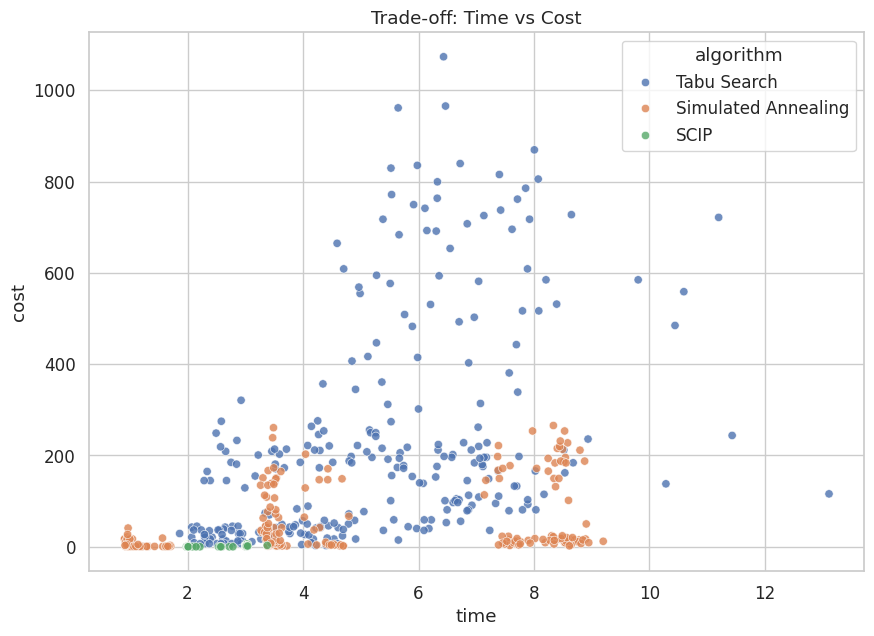

In [16]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x="time", y="cost", hue="algorithm", alpha=0.8)
plt.title("Trade-off: Time vs Cost")
plt.savefig(f"{OUTPUT_DIR}/tradeoff.png", dpi=300)
plt.show()
plt.close()


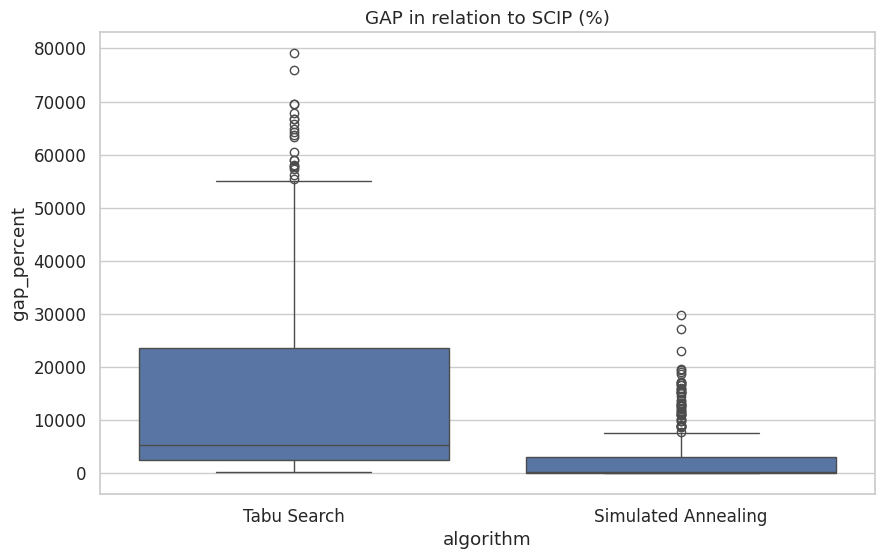

✅ GAP analysis done


In [17]:
# ============================================
# 7. GAP wrt SCIP (Quality comparison)
# ============================================

# Reference = SCIP
scip = df[df["algorithm"] == "SCIP"]

merged = df.merge(
    scip[["N", "K", "run", "cost"]],
    on=["N", "K", "run"],
    suffixes=("", "_scip")
)

merged["gap_percent"] = ((merged["cost"] - merged["cost_scip"]) / merged["cost_scip"]) * 100

merged.to_csv(f"{OUTPUT_DIR}/gap_data.csv", index=False)

# Plot GAP
plt.figure(figsize=(10,6))
sns.boxplot(data=merged[merged["algorithm"] != "SCIP"],
            x="algorithm", y="gap_percent")
plt.title("GAP in relation to SCIP (%)")
plt.savefig(f"{OUTPUT_DIR}/gap_boxplot.png", dpi=300)
plt.show()
plt.close()

print("✅ GAP analysis done")

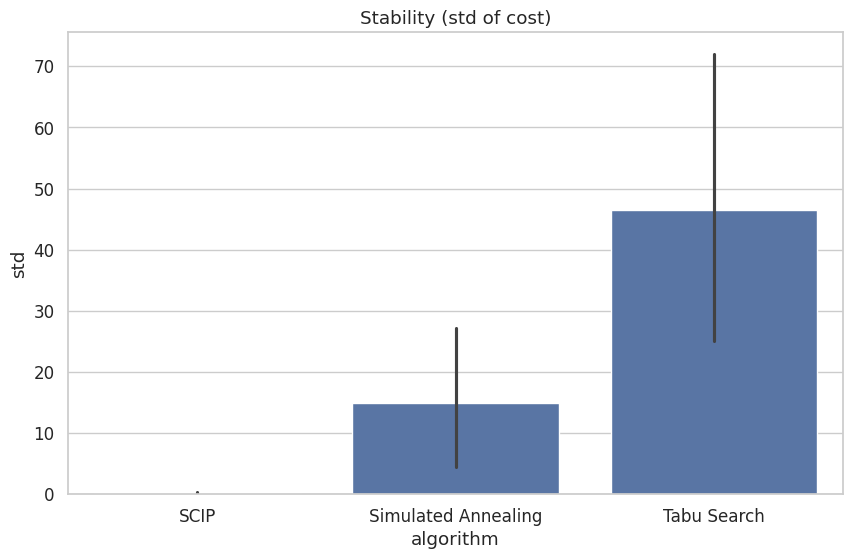

✅ Stability plot generated


In [18]:
# ============================================
# 8. Stability (std dev)
# ============================================

std_df = df.groupby(["N", "K", "algorithm"]).agg(std=("cost", "std")).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=std_df, x="algorithm", y="std")
plt.title("Stability (std of cost)")
plt.savefig(f"{OUTPUT_DIR}/stability.png", dpi=300)
plt.show()
plt.close()

print("✅ Stability plot generated")

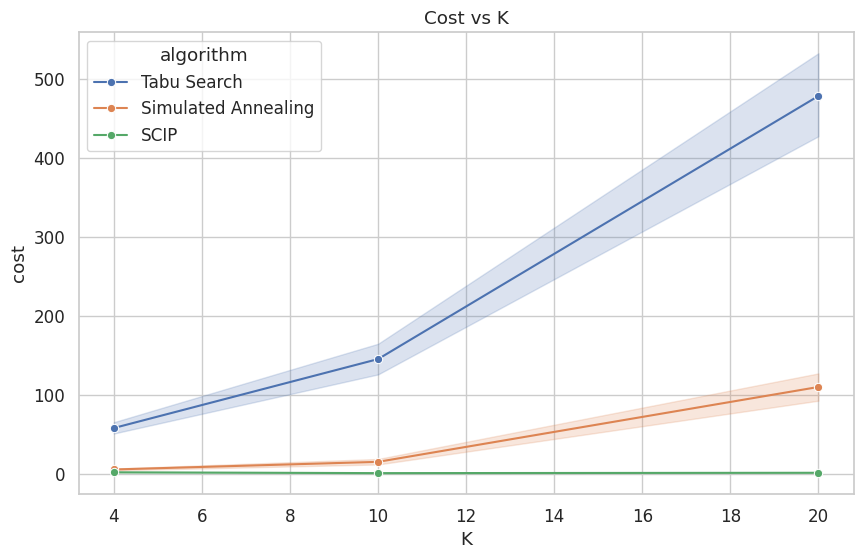

✅ Cost vs K plot generated


In [20]:
# ============================================
# 9. Performance across K
# ============================================

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="K", y="cost", hue="algorithm", marker="o")
plt.title("Cost vs K")
plt.savefig(f"{OUTPUT_DIR}/cost_vs_K.png", dpi=300)
plt.show()
plt.close()

print("✅ Cost vs K plot generated")

In [21]:
# ============================================
# 10. Ranking (normalized)
# ============================================

ranking = summary.copy()

# normalize
ranking["cost_norm"] = (ranking["mean_cost"] - ranking["mean_cost"].min()) / (
    ranking["mean_cost"].max() - ranking["mean_cost"].min()
)
ranking["time_norm"] = (ranking["mean_time"] - ranking["mean_time"].min()) / (
    ranking["mean_time"].max() - ranking["mean_time"].min()
)

ranking["score"] = 0.7 * ranking["cost_norm"] + 0.3 * ranking["time_norm"]

final_ranking = ranking.groupby("algorithm").agg(
    mean_score=("score", "mean"),
    mean_cost=("mean_cost", "mean"),
    mean_time=("mean_time", "mean")
).sort_values("mean_score")

final_ranking.to_csv(f"{OUTPUT_DIR}/final_ranking.csv")

Salvar análises

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
!ls "/content/drive/MyDrive/Colab Notebooks/Trabalho_IC"

BalanceamentoDeTimes.ipynb  plots


In [28]:
!cp -r /content/plots "/content/drive/MyDrive/Colab Notebooks/Trabalho_IC/plots"
